In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm

import os 
from glob import glob
import pandas as pd
import numpy as np
import cv2

In [3]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs

%load_ext autoreload
%autoreload 2

In [4]:
import colorsys
from multiprocessing import Pool

import shutil

In [5]:
labels = pd.read_csv(os.path.join(config.PATHS.CSV, 'labels.csv'))
paths = [os.path.join(config.PATHS.IMAGES, fnm) for fnm in labels.filename.unique()]
patients = [(os.path.basename(path), cv2.imread(path, 0)) for path in paths]
patients = sorted(patients, key=lambda x: int(x[0][4:-4]))

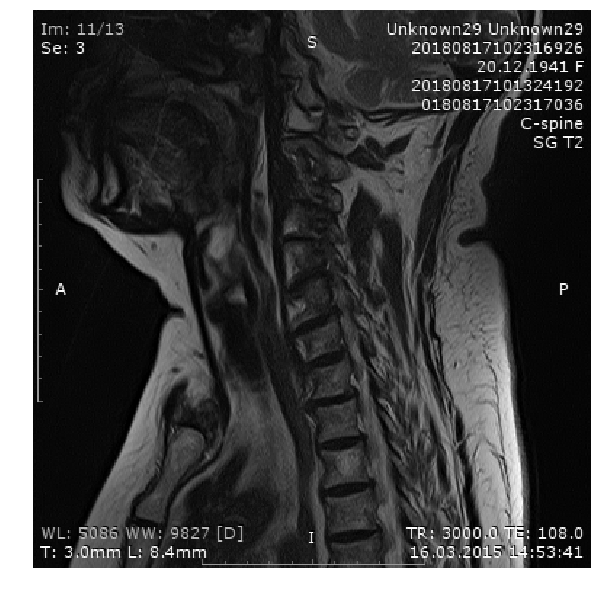

In [6]:
# PATIENT == 13
plt.figure(figsize=(10, 15))
plt.gray()
plt.imshow(cv2.imread('../data/images/img_01050.jpg', 0))
plt.axis('off');

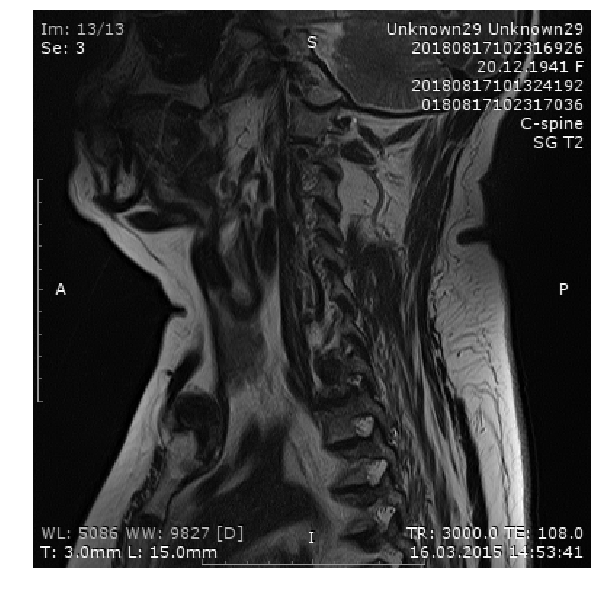

In [8]:
# PATIENT == 13
plt.figure(figsize=(10, 15))
plt.gray()
plt.imshow(cv2.imread('../data/images/img_01052.jpg', 0))
plt.axis('off');

### Weight connections

In [ ]:
connections = list()
for i, (_, refer) in enumerate(tqdm(patients)):
    flows = list()
    for j, (name, image) in enumerate(patients):
        if i == j:
            continue
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((j, name, mag.mean()))
    connections.append(flows)

  7%|▋         | 26/354 [05:29<1:09:21, 12.69s/it]

### Clique search

In [ ]:
def find_links(connections, init, links=[]):
    def check_branch(child):
        children = sorted(connections[child[0]], key=lambda x: x[2])[:2]
        idxs = [c[0] for c in children]
        if any(i in links for i in idxs):
            children = [i for i in idxs if i not in links]
            if len(children):
                find_links(connections, child[0], links)
            else:
                links.append(child[0])

    links.append(init)
    children = sorted(connections[init], key=lambda x: x[2])[:2]
    print((init, patients[init][0]), children)
    for c in children:
        check_branch(c)
    connections.remove()
    return set(links)
# children = sorted(connections[l], key=lambda x: x[2])[:2]

In [ ]:
i = 6
links = find_links(connections.copy(), i, [])
[patients[l][0] for l in links]

### Check consistency on skipped data:

In [13]:
connections = list()
for i, (_, refer) in enumerate(tqdm(patients[1:-1])):
    flows = list()
    for name, image in [patients[i], patients[i + 2]]:
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((name, mag.mean()))
    connections.append(flows)

100%|██████████| 352/352 [00:25<00:00, 13.80it/s]


In [9]:
paths = glob('../data/images/*.jpg')
paths = sorted(paths, key=lambda x: int(os.path.basename(x)[4:-4]))

connections = list()
for i, refer in enumerate(tqdm(paths[1:-1])):
    flows = list()
    refer = cv2.imread(refer, 0)
    for path in [paths[i], paths[i + 2]]:
        image = cv2.imread(path, 0)
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((os.path.basename(path), mag.mean()))
    connections.append(flows)

100%|██████████| 889/889 [01:09<00:00, 12.86it/s]


In [23]:
connections

[[('img_00000.jpg', 1.9980261), ('img_00002.jpg', 1.8928427)],
 [('img_00001.jpg', 1.870687), ('img_00003.jpg', 1.7042012)],
 [('img_00002.jpg', 1.6761752), ('img_00004.jpg', 1.4950955)],
 [('img_00003.jpg', 1.4598922), ('img_00005.jpg', 1.2402688)],
 [('img_00004.jpg', 1.2612133), ('img_00007.jpg', 1.7555095)],
 [('img_00005.jpg', 1.8694301), ('img_00008.jpg', 1.3217585)],
 [('img_00007.jpg', 1.2992324), ('img_00009.jpg', 1.4601136)],
 [('img_00008.jpg', 1.4477477), ('img_00010.jpg', 1.6700991)],
 [('img_00009.jpg', 1.6579496), ('img_00011.jpg', 1.7616595)],
 [('img_00010.jpg', 1.7181001), ('img_00012.jpg', 1.6864022)],
 [('img_00011.jpg', 1.6363611), ('img_00013.jpg', 10.931557)],
 [('img_00012.jpg', 12.668867), ('img_00014.jpg', 1.5937167)],
 [('img_00013.jpg', 1.6068264), ('img_00015.jpg', 1.599233)],
 [('img_00014.jpg', 1.676371), ('img_00016.jpg', 1.7353575)],
 [('img_00015.jpg', 1.8010104), ('img_00017.jpg', 1.6657232)],
 [('img_00016.jpg', 1.6970932), ('img_00018.jpg', 1.558334

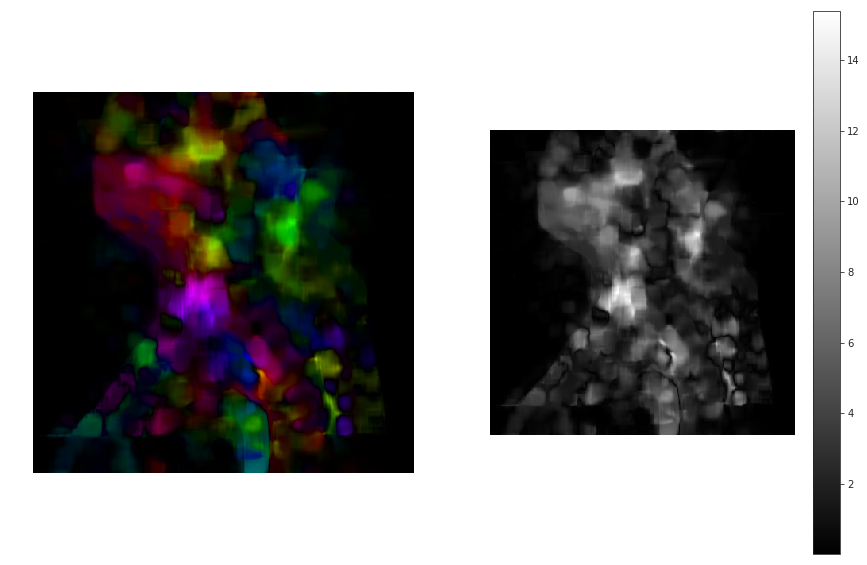

In [10]:
hsv = np.zeros(refer.shape + (3, ))
hsv[...,1] = 255

flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang * 180 / np.pi / 2
hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(bgr)
plt.axis('off');
plt.subplot(122)
plt.imshow(mag)
plt.colorbar()
plt.axis('off');